# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Feature shuffling, Feature performance and Target mean performance 

</font>
</div>

# Alternative feature selection methods
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- In this article, I will describe three algorithms that select features based on their impact on model performance. They are often referred to as "Hybrid Methods" because they share characteristics of Wrapper and Embedded methods. Some of these methods rely on training more than one machine learning model, a bit like wrapper methods. Some selection procedures rely on feature importance like Embedded Methods.

- But nomenclature aside, these methods have been successfully used in the industry or in data science competitions, and provide additional ways of finding the most predictive features for a certain machine learning model.

- There are three of them:
    - Feature shuffling
    - Feature performance
    - Target mean performance 

</font>
</div>

# Import modules
<hr style="border:2px solid black"> </hr>

In [24]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from feature_engine.selection import SelectByShuffling
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from feature_engine.selection import SelectByTargetMeanPerformance
import numpy as np

# Load the dataset
<hr style="border:2px solid black"> </hr>

In [25]:
# Load dataset No1
diabetes_X, diabetes_y = load_diabetes(return_X_y=True)
X = pd.DataFrame(diabetes_X)
y = pd.DataFrame(diabetes_y)

In [26]:
# Load dataset No2
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')


# extract cabin letter
data['cabin'] = data['cabin'].str[0]

# replace infrequent cabins by N
data['cabin'] = np.where(data['cabin'].isin(['T', 'G']), 'N', data['cabin'])

# cap maximum values
data['parch'] = np.where(data['parch']>3,3,data['parch'])
data['sibsp'] = np.where(data['sibsp']>3,3,data['sibsp'])

# cast variables as object to treat as categorical
data[['pclass','sibsp','parch']] = data[['pclass','sibsp','parch']].astype('O')

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['survived'], axis=1),
    data['survived'],
    test_size=0.3,
    random_state=0)

# Feature shuffling
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Feature shuffling, or permutation feature importance consists of assigning importance to a feature based on the decrease in a model performance score when the values of a single feature are randomly shuffled. 
- Shuffling the order of the feature values (across the rows of the dataset) alters the original relationship between the feature and the target, so the drop in the model performance score is indicative of how much the model depends on that feature.

</font>
</div>

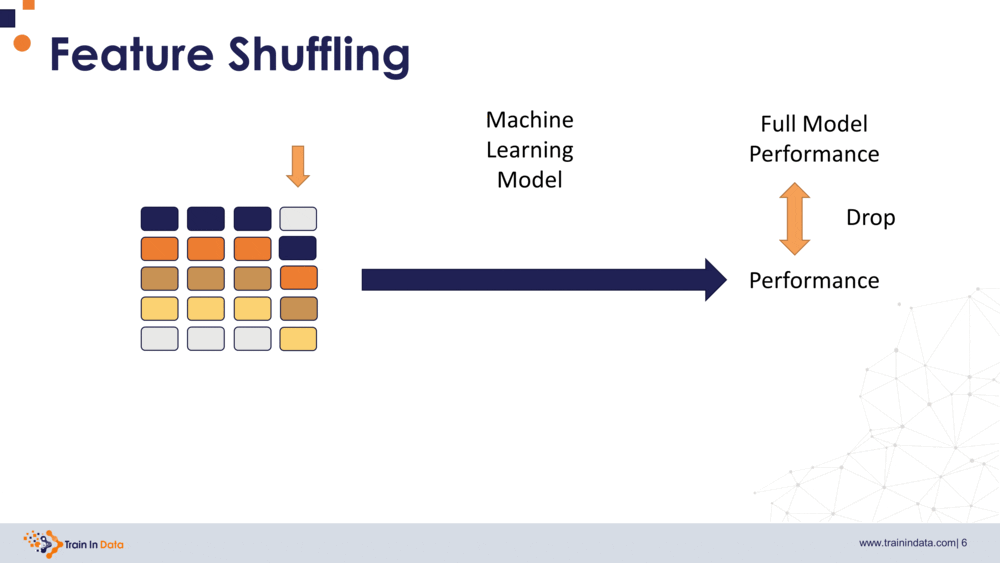

In [4]:
# Initialize linear regression estimator
linear_model = LinearRegression()

In [5]:
# Initialize the feature selector
tr = SelectByShuffling(estimator=linear_model, scoring="r2", cv=3)

<div class="alert alert-info">
<font color=black>

- With the method `fit()` the transformer finds the important variables —those that cause a drop in `r2` when shuffled. 
- By default, features will be selected if the performance drop is bigger than the mean drop caused by all features.

</font>
</div>

In [7]:
# Fit transformer
tr.fit(X, y)

SelectByShuffling(estimator=LinearRegression(), scoring='r2')

In [8]:
# With the method transform() we drop the unselected features from the dataset:
# We have a reduced dataframe in Xt.
Xt = tr.transform(X)

In [13]:
print("Original data shape", X.shape)
print("Reduced data shape", Xt.shape)

Original data shape (442, 10)
Reduced data shape (442, 4)


In [9]:
# We can inspect the individual feature’s importance through one of the transformer’s attributes:
tr.performance_drifts_

{0: -0.023216608298040564,
 1: 0.01492989695768987,
 2: 0.18880745383425623,
 3: 0.045937066720893815,
 4: 0.48950465906148555,
 5: 0.1379074827536586,
 6: -0.006228677681639538,
 7: 0.00028959087387869786,
 8: 0.3516703927427597,
 9: -0.016536361778217212}

In [10]:
# We can access to the names of the features that will be removed in another attribute:
tr.features_to_drop_

[0, 1, 3, 6, 7, 9]

# Feature performance
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- A direct way of determining the importance of a feature is to train a machine learning model using solely that feature.
- In this case, the "importance" of the feature is given by the performance score of the model. In other words, how well a model trained on a single feature predicts the target. 
- Poor performance metrics speak of weak or non-predictive features.

</font>
</div>

In [17]:
"""
Initialize the feature selector
We want to select features whose r2 > 0.01, utilizing a linear regression and using 3 fold cross-validation.
"""
sel = SelectBySingleFeaturePerformance(
        estimator=LinearRegression(), scoring="r2", cv=3, threshold=0.01)

In [18]:
# Fit transformer
sel.fit(X, y)

SelectBySingleFeaturePerformance(estimator=LinearRegression(), scoring='r2',
                                 threshold=0.01)

In [19]:
# We can explore the features that will be dropped:
sel.features_to_drop_

[1]

In [ ]:
# We can also examine each individual feature’s performance:
sel.feature_performance_

In [21]:
# Drop variables
Xt = sel.transform(X)

# Target mean performance
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

-  The selection procedure that I will discuss now was introduced in the KDD 2009 data science competition by Miller and co-workers. The authors do not attribute any name to the technique, but since it uses the mean target value per group of observations as a proxy for predictions, I like to call this technique "Selection by Target Mean Performance."

- This selection methodology also assigns an "importance" value to each feature. This importance value is derived from a performance metric. Interestingly, the model does not train any machine learning models. Instead, it uses a much simpler proxy as a prediction.

- In a nutshell, the procedure uses the mean target value per category or per interval (if the variable is continuous) as a proxy for prediction. With this prediction, it derives a performance metric, like r2, accuracy, or any other metric that assesses a prediction against the truth

</font>
</div>

In [27]:
# Feature-engine automates the selection of 
# categorical and numerical variables

sel = SelectByTargetMeanPerformance(
    variables=None,
    scoring="roc_auc_score",
    threshold=0.6,
    bins=3,
    strategy="equal_frequency",
    cv=2,# cross validation
    random_state=1, # seed for reproducibility
)

In [ ]:
# find important features
sel.fit(X_train, y_train)

In [ ]:
# We can explore the ROC-AUC for each feature:
sel.feature_performance_

In [ ]:
# We can find the features that will be dropped from the data:
sel.features_to_drop_

# Conclusions
<hr style="border:2px solid black"> </hr>

**Feature Shuffling**

<div class="alert alert-danger">
<font color=black>

- **Pros:**
    - It only trains one machine learning model, so it is quick.
    - It is suitable for any supervised machine learning model.
    - It is available in Feature-engine, a Python open source library. 
- **Cons**:
    - Correlations may affect the interpretation of the feature's importance.
    - The user needs to define an arbitrary threshold.
    - The element of randomness makes the selection procedure non-deterministic. 
    
</font>
</div>

**Feature performance**

<div class="alert alert-danger">
<font color=black>

- **Pros:**
    - It is suitable for any supervised machine learning model.
    - It explores features individually, thus avoiding correlation issues.
    - It is available in Feature-engine, a Python open source project.  
- **Cons**:
    - Training one model per feature can be computationally costly.
    - The user needs to define an arbitrary threshold.
    - It does not pick up feature interactions. 
    
</font>
</div>

**Target mean performance**

<div class="alert alert-danger">
<font color=black>

- **Pros:**
    - It is fast because no machine learning model is trained.
    - It is suitable for categorical and numerical variables alike.
    - It is robust to outliers.
    - It captures non-linear relationships between features and the target.
    - It is model-agnostic.  
- **Cons**:
    - It needs tuning of interval numbers for skewed variables.
    - Rare categories will offer unreliable performance proxies or make the method impossible to compute. 
    
</font>
</div>

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://www.kdnuggets.com/2021/12/alternative-feature-selection-methods-machine-learning.html
- [Feature-engine](https://feature-engine.readthedocs.io/en/latest/index.html)
- [Predicting customer behaviour: The University of Melbourne’s KDD Cup report](https://proceedings.mlr.press/v7/miller09/miller09.pdf)

</font>
</div>